# 模型裁剪

In [5]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.optim as optim

深度学习模型裁剪（Pruning）是一种优化技术，通过减少模型中的参数来降低其计算复杂度和存储需求，同时尽可能保持模型性能。以下是常见的模型裁剪方法：

裁剪场景的总结
使用时机	|适用场景	|优点	|缺点
---|---|---|---|
训练前	|已有明确的裁剪策略或稀疏结构需求	|提前减少模型复杂度，节省训练资源	|可能会影响模型初始性能
训练过程中	|动态稀疏性、逐步裁剪或基于训练过程调整裁剪策略	|灵活动态调整稀疏性，更容易控制模型性能	|增加了训练的复杂性
训练后	|对预训练模型进行压缩优化	|不影响训练过程，可直接应用到已训练好的模型	|可能需要微调以恢复裁剪导致的性能损失

最佳实践
- 如果目标是优化推理性能：建议在训练后使用裁剪，结合微调恢复性能。
- 如果目标是节省训练资源：可以在训练前裁剪，结合稀疏性训练。
- 如果目标是动态调整稀疏性：选择训练中裁剪，结合逐步裁剪方法（如 iterative pruning）。

## 权重级裁剪（Weight Pruning）

定义：直接将权重矩阵中的小权重（接近零的权重）设置为零。   
方法：
- 全局裁剪：全局地选择小于某个阈值的权重进行裁剪。
- 分层裁剪：针对每一层分别设置裁剪阈值，确保每层的重要性均衡。
  
优点：灵活，易实现。  
缺点：可能导致稀疏矩阵，无法直接提高硬件加速效果。

In [2]:
# 定义一个简单模型
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20, 10)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = SimpleModel()
print("Original model:", model)

# 对第一个全连接层的权重进行裁剪
prune.l1_unstructured(model.fc1, name='weight', amount=0.3)  # 裁剪30%的权重
print("Model after pruning:", model)

# 查看裁剪后的权重
print("Pruned weight matrix:\n", model.fc1.weight)

# 移除裁剪后产生的掩码（永久化裁剪效果）
prune.remove(model.fc1, 'weight')
print("After removing pruning:", model.fc1.weight)

Original model: SimpleModel(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
)
Model after pruning: SimpleModel(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
)
Pruned weight matrix:
 tensor([[-0.1199,  0.0000, -0.1932,  0.0000,  0.0000,  0.1765,  0.1008,  0.1464,
          0.1849, -0.2613],
        [-0.1732, -0.2893,  0.0000,  0.0000, -0.1734, -0.0000, -0.1881, -0.0983,
         -0.2661, -0.0984],
        [ 0.2228, -0.2964, -0.1743, -0.0000, -0.2952,  0.3142, -0.2945,  0.2322,
         -0.1544,  0.1497],
        [ 0.1685,  0.2131, -0.2918, -0.2657, -0.2932,  0.2701,  0.2129, -0.1973,
          0.1372, -0.0000],
        [ 0.1423,  0.2068,  0.1207, -0.0000,  0.0000,  0.0000,  0.1879, -0.0000,
          0.2540,  0.0000],
        [ 0.1718,  0.2132,  0.1636, -0.2630,  0.3034, -0.1297, -0.1317, -0.2207,
          0.2798, -0.1621],
        [ 0.2039

## 结构化裁剪（Structured Pruning）

定义：以更大的结构为单位进行裁剪，例如神经元、卷积核或通道。  
方法：
- 通道裁剪（Channel Pruning）：去掉冗余的卷积核或通道。
- 滤波器裁剪（Filter Pruning）：裁剪不重要的卷积核。
- 块裁剪（Block Pruning）：裁剪掉连续的参数块。

优点：对硬件友好，能直接减少计算量和存储需求。  
缺点：可能会丢失更多信息，调参复杂。

In [3]:
# 对卷积层的特定维度进行结构化裁剪
conv_layer = nn.Conv2d(3, 6, 3)

# 裁剪整个通道（Structured Pruning）
prune.ln_structured(conv_layer, name='weight', amount=0.5, n=2, dim=0)  # 保留50%的通道
print("Pruned convolutional layer:\n", conv_layer.weight)

Pruned convolutional layer:
 tensor([[[[ 0.0818,  0.0693,  0.1905],
          [ 0.1192,  0.0742, -0.1314],
          [ 0.1149, -0.0935,  0.1843]],

         [[ 0.0183, -0.0910, -0.0321],
          [-0.0871, -0.1826, -0.1558],
          [ 0.1444,  0.1415, -0.1535]],

         [[ 0.0281, -0.1639, -0.1781],
          [-0.1289, -0.0663, -0.1559],
          [-0.1092,  0.0808, -0.0514]]],


        [[[-0.0000, -0.0000,  0.0000],
          [-0.0000,  0.0000, -0.0000],
          [-0.0000,  0.0000,  0.0000]],

         [[ 0.0000, -0.0000, -0.0000],
          [-0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000, -0.0000]],

         [[ 0.0000, -0.0000, -0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000, -0.0000, -0.0000]]],


        [[[-0.1238, -0.1531,  0.1732],
          [-0.0641, -0.0635, -0.1834],
          [ 0.0961,  0.1230, -0.0719]],

         [[ 0.1923, -0.0091,  0.1423],
          [ 0.0225, -0.1631,  0.1666],
          [-0.0049, -0.1813,  0.0107]],

         [[ 0.0

## 基于正则化的裁剪

定义：通过在训练过程中引入额外的正则化项，使部分参数自然趋于零。  
常见方法：
- L1正则化：添加 L1 范数约束，让不重要的参数趋向零。
- Group Lasso：针对分组的结构化裁剪。
  
优点：无需显式裁剪步骤，参数自然变稀疏。  
缺点：训练过程复杂，可能增加训练时间。

In [7]:
# 定义模型
model = SimpleModel()

# 定义优化器和L1正则化
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5)  # L2正则化
l1_lambda = 1e-4  # L1正则化系数

# 训练循环
for epoch in range(5):
    for batch in range(10):  # 模拟数据训练
        inputs = torch.randn(32, 10)
        targets = torch.randn(32, 10)
        
        # 前向传播
        outputs = model(inputs)
        loss = torch.nn.functional.mse_loss(outputs, targets)
        
        # 添加L1正则化
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm
        print(loss)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

tensor(1.2798, grad_fn=<AddBackward0>)
tensor(1.1328, grad_fn=<AddBackward0>)
tensor(1.1576, grad_fn=<AddBackward0>)
tensor(1.2264, grad_fn=<AddBackward0>)
tensor(1.0927, grad_fn=<AddBackward0>)
tensor(1.0248, grad_fn=<AddBackward0>)
tensor(1.0389, grad_fn=<AddBackward0>)
tensor(1.1160, grad_fn=<AddBackward0>)
tensor(1.3103, grad_fn=<AddBackward0>)
tensor(1.1671, grad_fn=<AddBackward0>)
tensor(1.1784, grad_fn=<AddBackward0>)
tensor(1.1616, grad_fn=<AddBackward0>)
tensor(1.1381, grad_fn=<AddBackward0>)
tensor(1.1945, grad_fn=<AddBackward0>)
tensor(1.1590, grad_fn=<AddBackward0>)
tensor(1.1085, grad_fn=<AddBackward0>)
tensor(1.0255, grad_fn=<AddBackward0>)
tensor(1.2537, grad_fn=<AddBackward0>)
tensor(1.0417, grad_fn=<AddBackward0>)
tensor(1.0126, grad_fn=<AddBackward0>)
tensor(1.1518, grad_fn=<AddBackward0>)
tensor(1.1390, grad_fn=<AddBackward0>)
tensor(0.9792, grad_fn=<AddBackward0>)
tensor(1.0338, grad_fn=<AddBackward0>)
tensor(1.0508, grad_fn=<AddBackward0>)
tensor(1.1590, grad_fn=<A

## 动态裁剪（Dynamic Pruning）

定义：在推理过程中动态调整裁剪策略。  
方法：
- 根据输入数据动态关闭部分网络通路。
- 使用门控机制（如可学习的Gate）。
  
优点：灵活适应不同输入，能进一步减少实时计算量。  
缺点：实现复杂，可能导致额外的动态计算开销。

In [8]:
# 自定义裁剪机制
def dynamic_pruning(module, input, output):
    with torch.no_grad():
        module.weight.data[module.weight.data.abs() < 0.1] = 0  # 动态清零小权重

# 动态裁剪的实现
model = SimpleModel()
model.fc1.register_forward_hook(dynamic_pruning)  # 添加动态裁剪到前向传播钩子

# 模拟输入
inputs = torch.randn(32, 10)
outputs = model(inputs)  # 在推理过程中动态裁剪权重

# 梯度裁剪

在深度学习中，尤其是 RNN 或 LSTM 等递归模型中，梯度爆炸会导致数值不稳定，损失无法正常下降。梯度裁剪通过限制梯度的大小，帮助模型在训练过程中更稳定地优化。

## 基于梯度范数的裁剪

torch.nn.utils.clip_grad_norm_ 的主要功能是限制模型参数的梯度范数。如果梯度的总范数超过设定的阈值 clip_value，就会将其缩放到阈值范围内。

In [9]:
# 定义简单模型
model = nn.Linear(10, 1)

# 定义优化器
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 模拟训练循环
for epoch in range(5):
    inputs = torch.randn(32, 10)
    targets = torch.randn(32, 1)
    
    # 前向传播
    outputs = model(inputs)
    loss = torch.nn.functional.mse_loss(outputs, targets)
    
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    
    # 梯度裁剪
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 限制梯度的L2范数不超过1.0
    # torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=0.5)  # 限制梯度值在 [-0.5, 0.5] 之间
    
    # 参数更新
    optimizer.step()

## 基于梯度值的裁剪

直接裁剪梯度的值，使其限制在特定范围。

In [10]:
# 定义简单模型
model = nn.Linear(10, 1)

# 定义优化器
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 模拟训练循环
for epoch in range(5):
    inputs = torch.randn(32, 10)
    targets = torch.randn(32, 1)
    
    # 前向传播
    outputs = model(inputs)
    loss = torch.nn.functional.mse_loss(outputs, targets)
    
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    
    # 梯度裁剪
    torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=0.5)  # 限制梯度值在 [-0.5, 0.5] 之间
    
    # 参数更新
    optimizer.step()

## 动态梯度裁剪 

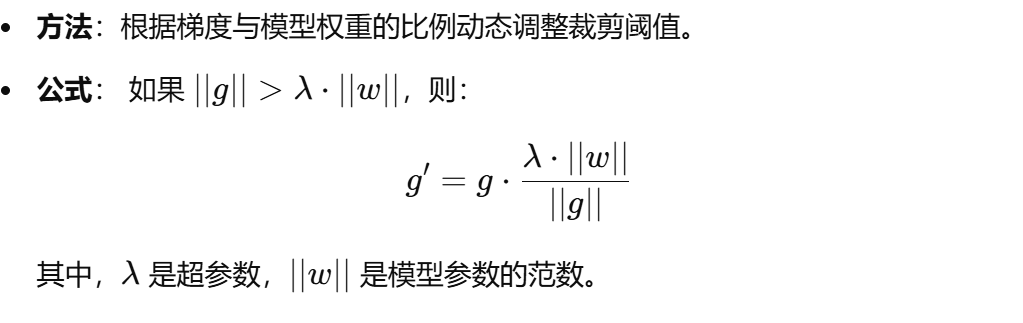

In [11]:
def adaptive_gradient_clipping(parameters, clip_factor=0.01):
    for param in parameters:
        if param.grad is not None:
            grad_norm = param.grad.data.norm(2)
            param_norm = param.data.norm(2)
            clip_value = clip_factor * param_norm
            if grad_norm > clip_value:
                param.grad.data.mul_(clip_value / grad_norm)

In [12]:
# 定义简单模型
model = nn.Linear(10, 1)

# 定义优化器
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 模拟训练循环
for epoch in range(5):
    inputs = torch.randn(32, 10)
    targets = torch.randn(32, 1)
    
    # 前向传播
    outputs = model(inputs)
    loss = torch.nn.functional.mse_loss(outputs, targets)
    
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    
    # 动态梯度裁剪
    adaptive_gradient_clipping(model.parameters(), clip_factor=0.01)
    
    # 参数更新
    optimizer.step()

# 模型裁剪和梯度裁剪区别

梯度裁剪	|模型裁剪
---|---
作用于梯度：在反向传播过程中，对梯度进行裁剪，防止梯度爆炸或不稳定。	|作用于权重或结构：直接减少模型权重或结构中的参数，优化推理效率。
目标：改善训练的稳定性。	|目标：减少模型复杂度和计算量。
方法：如 clip_grad_norm_ 或 clip_grad_value_。	|如权重裁剪、通道裁剪、滤波器裁剪等。
不影响推理阶段。	|影响推理阶段，通过减少模型规模加速推理。